In [69]:
import os
import sys
import pathlib
import glob

root = pathlib.Path("..").resolve()
output_dir = os.path.join(root, "test", "output")

# scientific packages
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as pltc
from IPython.display import display
from scipy.optimize import fmin


In [2]:
# Load RouteLink data, CONUS Full Res
rl = (xr.open_dataset(os.path.join(root, "test", "input", "geo", "Channels", "RouteLink_NHDPLUS.nwm.v2.0.4.nc")).
      to_dataframe().
      drop(['gages','ascendingIndex','Kchan','MusK','MusX','from','time','Qi'], axis = 1).
      set_index('link')
     )

# Load gage peak flow data
pk = (pd.read_csv(os.path.join(root,"usgs_gage_analysis","usgs_record_peaks.csv")).
      set_index('link').
      drop(['peak_dt', 'Unnamed: 0'], axis = 1)
     )

# join dataframes
rl_pk = rl.join(pk, how = 'right')


In [101]:
# compute normal depth for the gaged record peak flow
rl_pk['normal_depth_m'] = rl_pk.apply(lambda x: normal_depth(x.BtmWdth,
                                                             x.n,
                                                             x.So,
                                                             x.peak_cms,
                                                             x.ChSlp,
                                                             x.TopWdth,
                                                             x.TopWdthCC,
                                                             x.nCC
                                                            ), axis = 1) 

rl_pk['conveyance_cms'] = rl_pk.apply(lambda x: conveyance_capacity(x.BtmWdth,
                                                             x.n,
                                                             x.So,
                                                             x.peak_cms,
                                                             x.ChSlp,
                                                             x.TopWdth
                                                            ), axis = 1) 

# compute the courant number of the peak flow, assuming 300 second timestep and existing dx
rl_pk['courant_peak'] = rl_pk.apply(lambda x: courant(x.normal_depth_m,
                                                   x.ChSlp,
                                                   x.TopWdth,
                                                   x.BtmWdth,
                                                   x.TopWdthCC,
                                                   x.So,
                                                   x.n,
                                                   x.nCC,
                                                   300,
                                                   x.Length
                                                  ), axis = 1)

# find the minimum viable segment length to maintain numerical stability during peak flow
rl_pk['stable_dx_m'] = rl_pk.apply(lambda x: stable_segment_length(x.normal_depth_m,
                                                                   x.ChSlp,
                                                                   x.TopWdth,
                                                                   x.BtmWdth,
                                                                   x.TopWdthCC,
                                                                   x.So,
                                                                   x.n,
                                                                   x.nCC,
                                                                   300
                                                                  ), axis = 1)


<ipython-input-31-06be2a07127f>:33: RuntimeWarning: invalid value encountered in power
  return (1 / n) *(AREA) * ((R)**(2/3)) * (np.sqrt(s0))
<ipython-input-31-06be2a07127f>:16: RuntimeWarning: invalid value encountered in power
  q_cc = (1/ncc) * AREAC * (AREAC/WPC)**(2/3) * (np.sqrt(s0))
<ipython-input-5-996f88415314>:40: RuntimeWarning: divide by zero encountered in true_divide
  cn = ck * (dt/dx)


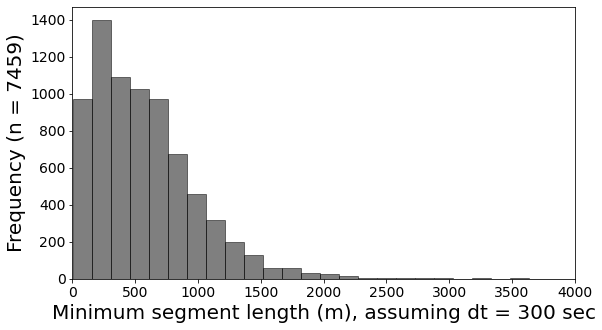

In [118]:
ax = rl_pk.loc[:,'stable_dx_m'].hist(bins = 100,figsize = (9,5), facecolor = 'k', edgecolor = 'k',alpha = 0.5)
ax.set_xlim(0, 4000)
ax.grid(False)
ax.set_ylabel("Frequency (n = 7459)", fontsize = 20)
ax.set_xlabel("Minimum segment length (m), assuming dt = 300 sec", fontsize = 20)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.show()

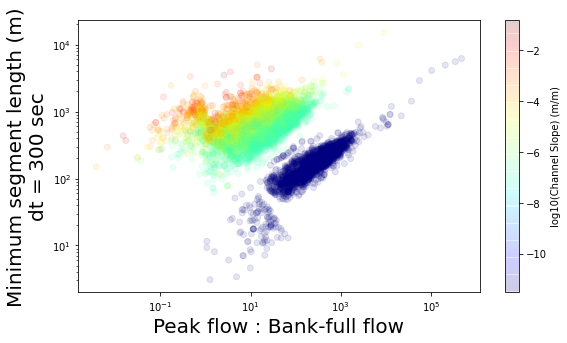

In [132]:
# df_plot = rl_pk[['order','stable_dx_m']].rename(columns = {'stable_dx_m':'Segment length required for stable M-C simulation (meters)'}).groupby('order').describe()
# df_plot

fig = plt.figure(figsize = (9,5))
sc = plt.scatter(y = (rl_pk.stable_dx_m), x = (rl_pk.peak_cms/rl_pk.conveyance_cms), alpha = 0.1, c = np.log(rl_pk.So), cmap = 'jet')
plt.yscale('log')
plt.xscale('log')
plt.colorbar(sc, label = 'log10(Channel Slope) (m/m)')
plt.ylabel(r'Minimum segment length (m)' + '\n' + r'dt = 300 sec', fontsize = 20)
plt.xlabel('Peak flow : Bank-full flow', fontsize = 20)
plt.show()


In [31]:
def manning_q_bfd(y, n, s0, bw, cs, bfd, twcc, ncc):
    """ compute flow using Manning's equation """
    z = 1.0/cs
    
    # channel geometry
    AREA =  (bw + bfd * z) * bfd
    AREAC = (twcc * (y - bfd)) 
    WP = (bw + 2 * bfd * np.sqrt(1 + z*z))
    WPC = twcc + (2 * (y - bfd))
    R   = (AREA + AREAC)/(WP + WPC)
    
    # flow in main, trapezoidal  channel @ bfd
    q_mc = (1/n) * AREA * (AREA/WP)**(2/3) * (np.sqrt(s0))
    
    # flow in rectangulat floodplane, over bfd
    q_cc = (1/ncc) * AREAC * (AREAC/WPC)**(2/3) * (np.sqrt(s0))
    
    return q_mc + q_cc

def flow_min_bfd(y, n, s0, q, bw, cs, bfd, twcc, ncc):
    """ computes the error term comparing the Manning's computed depth with the given Q """
    epsilon = np.abs(manning_q_bfd(y, n, s0, bw, cs, bfd, twcc, ncc) - q)
    return epsilon

def manning_q(y, n, s0, bw, cs):
    """ compute flow using Manning's equation """
    z = 1.0/cs
    
    AREA = (bw + y * z ) * y
    WP = (bw + 2 * y * np.sqrt(1 + z*z))
    R = AREA / WP
    
    return (1 / n) *(AREA) * ((R)**(2/3)) * (np.sqrt(s0))

def flow_min(y, n, s0, q, bw, cs):
    """ computes the error term comparing the Manning's computed depth with the given Q """
    epsilon = np.abs(manning_q(y, n, s0, bw, cs) - q)
    return epsilon

def normal_depth(bw, n, s0, q, cs, tw, twcc, ncc):
    """ function to compute error in depth calculation for a guessed depth compared to a calculated depth for a given flow.
        Uses scipy.optimize fmin """
    
    # calculate normal depth in trapezoidal channel
    y_optimum = fmin(
        flow_min, q / bw / 3, args=(n, s0, q, bw, cs), full_output=True, disp=False
    )
    yn_trap = float(y_optimum[0])
    
    # check if yn_trap is over bank full
    z = 1.0/cs
    bfd = bfd =  (tw - bw)/(2*z)
    if yn_trap > bfd:
        # calculate normal depth in compound channel
        y_optimum = fmin(
            flow_min_bfd, q / bw / 3, args=(n, s0, q, bw, cs, bfd, twcc, ncc), full_output=True, disp=False
        )
        yn = float(y_optimum[0])
    else:
        yn = yn_trap
        
    return(yn)

def conveyance_capacity(bw, n, s0, q, cs, tw):
    z = 1.0/cs
    bfd = bfd =  (tw - bw)/(2*z)
    return(manning_q(bfd, n, s0, bw, cs))

In [5]:
# calculate kinematic celerity and courant number from model parameters and output from f2py process
def courant(depthc, cs, tw, bw, twcc, s0, n, ncc, dt, dx):
    
    # channel side distance
    z = 1.0/cs

    # bankfull depth (assumes tw > bw)
    bfd =  (tw - bw)/(2*z)
    
    if depthc > bfd:

        # ******* when depth is above bank full *******
        h = depthc

        AREA =  (bw + bfd * z) * bfd
        AREAC = (twcc * (h - bfd)) 
        WP = (bw + 2 * bfd * np.sqrt(1 + z*z))
        WPC = twcc + (2 * (h - bfd))
        R   = (AREA + AREAC)/(WP + WPC)

        ck =  ((np.sqrt(s0)/n)*((5/3)*R**(2/3) - \
                    ((2/3)*R**(5/3)*(2*np.sqrt(1 + z*z)/(bw+2*bfd*z))))*AREA \
                    + ((np.sqrt(s0)/(ncc))*(5/3)*(h - bfd)**(2/3))*AREAC)/(AREA+AREAC)
        
    else:

        # ******* when depth is below bank full ********
        h = depthc
        
        AREA = (bw + h * z ) * h
        WP = (bw + 2 * h * np.sqrt(1 + z*z))
        R = AREA / WP

        ck = (np.sqrt(s0)/n)* \
                        ((5/3)*R**(2/3)-((2/3)*R**(5/3)* \
                         (2*np.sqrt(1 + z*z)/(bw+2*h*z))))


    # Courant number
    cn = ck * (dt/dx)
    
    return cn

def c_min(dx, depthc, cs, tw, bw, twcc, s0, n, ncc, dt):
    epsilon = np.abs(courant(depthc, cs, tw, bw, twcc, s0, n, ncc, dt, dx) - 1)
    return epsilon

def stable_segment_length(yn, cs, tw, bw, twcc, s0, n, ncc, dt):
    
    # calculate normal depth in trapezoidal channel
    dx_optimum = fmin(
        c_min, 1000, args=(yn, cs, tw, bw, twcc, s0, n, ncc, dt), full_output=True, disp=False
    )
    return(float(dx_optimum[0]))

In [95]:
rl_pk

,to,lon,lat,alt,order,Length,n,So,ChSlp,BtmWdth,NHDWaterbodyComID,nCC,TopWdthCC,TopWdth,site_no,peak_cms,normal_depth_m,courant_peak,stable_dx_m,conveyance_cms
link,,,,,,,,,,,,,,,,,,,,
3109,3113,-68.156685,45.705746,134.490005,3,10916.000000,0.055,0.00300,0.376480,7.795193,-9999,0.11,38.975964,12.991988,1030350,42.19,2.412019,0.006159,67.232037,8.445134
3923,6087,-68.299759,45.505806,69.769997,5,1616.000000,0.050,0.00400,0.229824,23.860435,-9999,0.10,119.302177,39.767391,1030500,1319.56,7.345335,0.122584,198.095417,94.113937
12932,12888,-105.064072,40.379154,1507.540039,5,5297.000000,0.050,0.00300,0.265942,17.139132,-9999,0.10,85.695656,28.565218,6741510,538.02,5.789117,0.027396,145.116138,42.921245
13584,13100,-105.578583,40.350464,2443.179932,3,1382.000000,0.055,0.04700,0.392394,7.096934,-9999,0.11,35.484673,11.828224,402114105350101,32.00,1.112826,0.091552,126.525021,27.844329
66922,56754,-80.174011,26.940229,4.030000,1,3639.000000,0.060,0.00100,0.436143,5.584890,-9999,0.12,27.924452,9.308150,2277600,75.32,5.234392,0.019136,69.637108,2.333733
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1131000968,1131000971,-102.977989,29.186159,578.299988,8,2746.500000,0.045,0.00900,0.128059,89.821609,-9999,0.09,449.108032,149.702682,8375300,1407.34,3.120461,0.127043,348.924828,2039.191571
1150000651,1150000648,-110.929840,31.359468,1156.250000,3,2489.800049,0.055,0.00800,0.388500,7.259171,-9999,0.11,36.295856,12.098619,9481000,181.51,3.976618,0.068300,170.053959,12.004689
1170022657,1171000230,-117.639824,48.989445,400.899994,9,3226.300049,0.040,0.00200,0.131252,84.943726,-9999,0.08,424.718597,141.572876,12399500,19255.42,17.614232,0.099495,321.000576,970.782861
